In [123]:
"""  Apr 26, 2016

     Load AGCM runs and search for time periods of significant cooling
     
"""

import cccmaplots as cplt
import cccmaNC as cnc
import cccmautils as cutl
import constants as con
import cccmacmaps as ccm
import platform as platform
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import numpy.ma as ma
import pandas as pd
import loadmodeldata as lmd


%matplotlib inline


local=True


In [124]:
def runmean(input, window=5,axis=0) :
    ret = np.cumsum(input, dtype=float,axis=axis)
    ret[window:,...] = ret[window:,...] - ret[:-window,...]
    return ret[window - 1:,...] / np.float(window)


In [125]:
# load the data
sea='DJF'

field='tas'
sims=('R1','R2','R3','R4','R5')
esims=('E1','E2','E3','E4','E5')
region='eurasiathicke' #'eurasialarge' #'eurasiamori'
styearsR = [ 8.,  7.,  2.,  8.,  8.]

simconv1=1
if field=='tas': simfield1='st'; simncfield1='ST'
elif field=='zg50000.00': simfield1='gz50000'; simncfield1='PHI'; simconv1=1/con.get_g()
elif field=='sia': simfield1='sicn'; simncfield1='SICN'; print '@@ danger, sia actually sicn average'
elif field=='sic': simfield1='sicn'; simncfield1='SICN';
else: print 'cannot addsims for ' + field;

simflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region))*simconv1

simctldf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,filetype='ctl'))*simconv1
simptdf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,filetype='pert'))*simconv1

# try with E sims too:
esimctldf = pd.DataFrame(lmd.loaddata((simfield1,),esims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,filetype='ctl'))*simconv1
esimptdf = pd.DataFrame(lmd.loaddata((simfield1,),esims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,filetype='pert'))*simconv1


# also do 'ND'
sea2 = 'ND'
simfldnddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea2, region=region))*simconv1


# also do 'JF'
sea3 = 'JF'
simfldjfdf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea3, region=region))*simconv1


@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_st_001-121_ts.nc
lat: squeezing data upon read all
lo

(595,)
(119, 5)


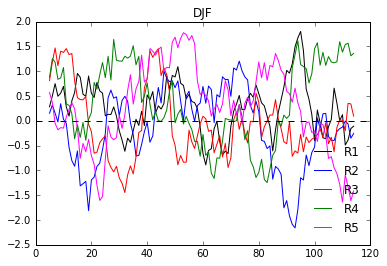

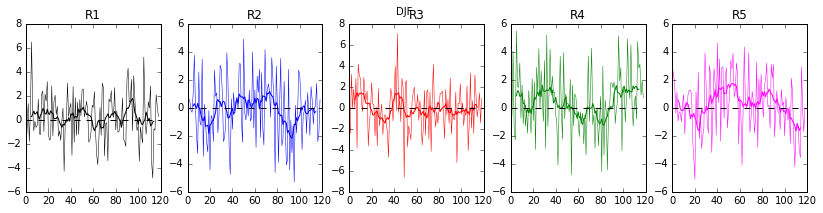

In [126]:
# =============== DJF =================
print simyrs.shape
print simflddf.values.shape


xx=np.arange(0,simflddf.shape[0]) # numyears
window=10
xxrun = xx[window/2:-window/2+1]

clrs=('k','b','r','g','magenta')
clrdt={'R1':'k',
      'R2':'b',
      'R3': 'r',
      'R4': 'g',
      'R5': 'magenta'}
eclrdt={'E1':'k',
      'E2':'b',
      'E3': 'r',
      'E4': 'g',
      'E5': 'magenta'}

lgstr = simflddf.keys()


plt.figure()
for ii in range(0,simflddf.shape[1]):
    
    #plt.plot(xx,simflddf.values[:,ii],color=clrs[ii])
    plt.plot(xxrun, runmean(simflddf.values[:,ii], window=window),color=clrs[ii])

plt.axhline(y=0,linestyle='--',color='k')
plt.legend(lgstr,frameon=False,loc='best')
plt.title(sea)

fig,axs = plt.subplots(1,5,figsize=(14,3))
for ii in range(0,simflddf.shape[1]):
    ax=axs[ii]
    ax.plot(xx,simflddf.values[:,ii],color=clrs[ii],linewidth=.5)
    ax.plot(xxrun, runmean(simflddf.values[:,ii], window=window),color=clrs[ii])

    ax.set_title(simflddf.keys()[ii])
    ax.axhline(y=0,linestyle='--',color='k')
fig.suptitle(sea)

In [127]:
# cherry pick R2 for DJF cold periods
r2 = simflddf['R2']
print r2.shape


# get r2 ctl and pert separately
r2ctl = simctldf['R2']
r2pt = simptdf['R2']


r3 = simflddf['R3']

# get r3 ctl and pert separately
r3ctl = simctldf['R3']
r3pt = simptdf['R3']

(119,)


In [128]:
# ====================== DJF
def slide_avg(ctl,pert,slide=60):
    
    diffary = np.zeros_like(ctl)
    pvalary = np.zeros_like(ctl)
    for styear in np.arange(0,len(ctl)):

        enyear = styear+slide
        #print styear,enyear
        diffary[styear] = (pert[styear:enyear] - ctl[styear:enyear]).mean()
        _,pvalary[styear] = cutl.ttest_ind(ctl[styear:enyear],pert[styear:enyear])
        
    diffsig = ma.masked_where(pvalary>0.05,diffary)
    return diffary, diffsig, pvalary

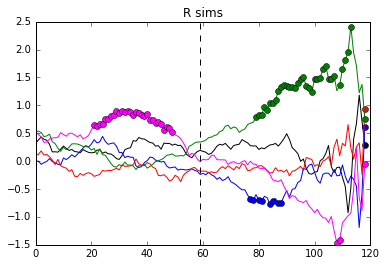

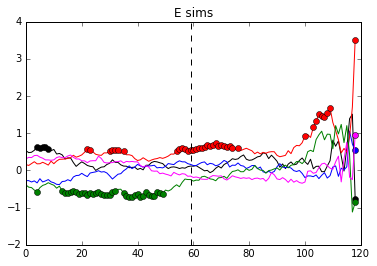

In [129]:
slide=60

df={}; dfs={}; pv={}
fig,ax=plt.subplots(1,1)
for skey in simctldf.keys():
    
    ctl = simctldf[skey]
    pert = simptdf[skey]
        
    df[skey],dfs[skey],pv[skey] = slide_avg(ctl,pert,slide=slide)

    ax.plot(df[skey],color=clrdt[skey])
    ax.plot(dfs[skey],marker='o',linestyle='none',color=clrdt[skey])
    
ax.axvline(x=len(ctl)-slide,linestyle='--',color='k')
#ax.legend(simctldf.keys(), frameon=False,loc='best')
ax.set_title('R sims')

edf={}; edfs={}; epv={}
fig,ax=plt.subplots(1,1)
for skey in esimctldf.keys():
    
    ctl = esimctldf[skey]
    pert = esimptdf[skey]
        
    edf[skey],edfs[skey],epv[skey] = slide_avg(ctl,pert,slide=slide)

    ax.plot(edf[skey],color=eclrdt[skey])
    ax.plot(edfs[skey],marker='o',linestyle='none',color=eclrdt[skey])
    
ax.axvline(x=len(ctl)-slide,linestyle='--',color='k')
ax.set_title('E sims')

nrows: 3 ncols: 14
lat: squeezing data upon read all
lon: squeezing data upon read all


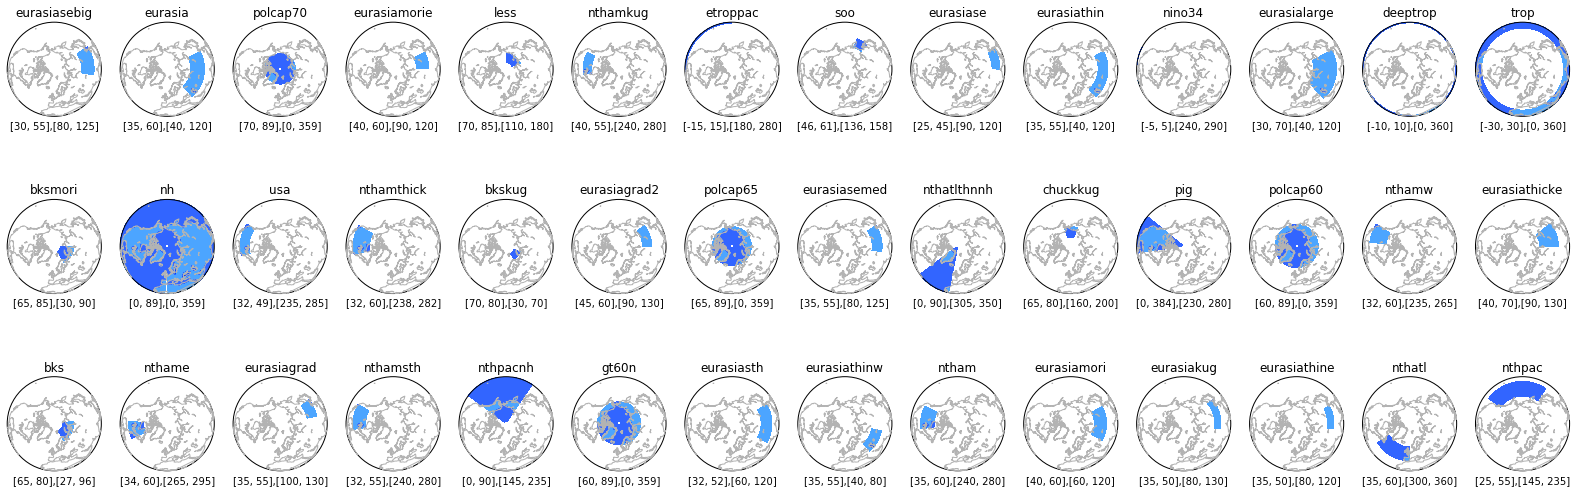

In [113]:
cplt.plot_allregions()

In [77]:
styear = 77; enyear=117   # 77
tstat,pval = cutl.ttest_ind(r2ctl[styear:enyear],r2pt[styear:enyear])

print sea
print str(styear) + '-' + str(enyear) + ' years of R2'
print 'diff ' + str(r2[styear:enyear].mean())
print 'tstat,pval ' + str(tstat),str(pval)


styear = 60
tstat,pval = cutl.ttest_ind(r2ctl[styear:],r2pt[styear:])

print '\nlast 60 years of R2'
print 'diff ' + str(r2[styear:].mean())
print 'tstat,pval ' + str(tstat),str(pval)

print '\ncompare to full time period'

tstat,pval = cutl.ttest_ind(r2ctl,r2pt)
print 'diff ' + str(r2.mean())
print 'tstat,pval ' + str(tstat),str(pval)


styear = 50; enyear = 110
tstat,pval = cutl.ttest_ind(r3ctl[styear:enyear],r3pt[styear:enyear])

print '\n50-110 years of R3'
print 'diff ' + str(r3[styear:enyear].mean())
print 'tstat,pval ' + str(tstat),str(pval)


print '\ncompare to full time period'

tstat,pval = cutl.ttest_ind(r3ctl,r3pt)
print 'diff ' + str(r3.mean())
print 'tstat,pval ' + str(tstat),str(pval)

DJF
77-117 years of R2
diff -0.696423731507
tstat,pval [ 2.06029079] [ 0.04270531]

last 60 years of R2
diff -0.208320270283
tstat,pval [ 0.77614454] [ 0.43924327]

compare to full time period
diff -0.104848020492
tstat,pval [ 0.57288505] [ 0.56726794]

50-110 years of R3
diff -0.231097275762
tstat,pval [ 0.87557222] [ 0.38304144]

compare to full time period
diff -0.00995005676355
tstat,pval [ 0.05416252] [ 0.95685151]


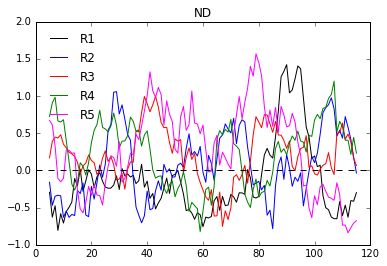

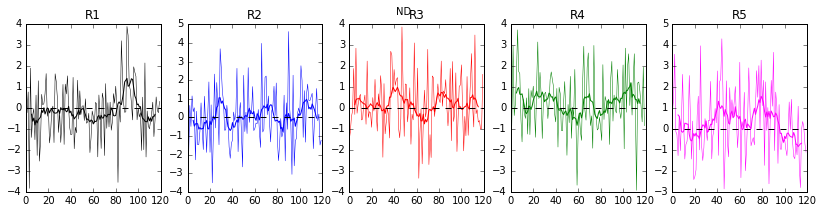

In [121]:
# ============= ND ===============
xx=np.arange(0,simfldnddf.shape[0]) # numyears
window=10
xxrun = xx[window/2:-window/2+1]

plt.figure()
for ii in range(0,simfldnddf.shape[1]):
    
    #plt.plot(xx,simflddf.values[:,ii],color=clrs[ii])
    plt.plot(xxrun, runmean(simfldnddf.values[:,ii], window=window),color=clrs[ii])

plt.axhline(y=0,linestyle='--',color='k')
plt.legend(lgstr,frameon=False,loc='best')
plt.title(sea2)

fig,axs = plt.subplots(1,5,figsize=(14,3))
for ii in range(0,simfldnddf.shape[1]):
    ax=axs[ii]
    ax.plot(xx,simfldnddf.values[:,ii],color=clrs[ii],linewidth=.5)
    ax.plot(xxrun, runmean(simfldnddf.values[:,ii], window=window),color=clrs[ii])

    ax.set_title(simfldnddf.keys()[ii])
    ax.axhline(y=0,linestyle='--',color='k')
fig.suptitle(sea2)

In [ ]:
# cherry pick R1 for ND cold periods

r1nd=simfldnddf['R1']
# get r2 ctl and pert separately
r1ndctl = pd.DataFrame(lmd.loaddata((simfield1,),('R1',),ncfields=(simncfield1,), 
                                     timefreq=sea2, region=region,filetype='ctl'))*simconv1
r1ndpt = pd.DataFrame(lmd.loaddata((simfield1,),('R1',),ncfields=(simncfield1,), 
                                     timefreq=sea2, region=region,filetype='pert'))*simconv1


In [48]:
# ========================== ND

styear=30; enyear=80

tstat,pval = cutl.ttest_ind(r2ctl[styear:enyear],r2pt[styear:enyear])

print '\n' + sea2
print '30-80 years of R1'
print 'diff ' + str(r1nd[styear:enyear].mean())
print 'tstat,pval ' + str(tstat),str(pval)



styear = 0; enyear=60
tstat,pval = cutl.ttest_ind(r1ndctl[styear:enyear],r1ndpt[styear:enyear])

print '\nfirst 60 years of R1'
print 'diff ' + str(r1nd[styear:enyear].mean())
print 'tstat,pval ' + str(tstat),str(pval)

print '\ncompare to full time period'

tstat,pval = cutl.ttest_ind(r1ndctl,r1ndpt)
print 'diff ' + str(r1nd.mean())
print 'tstat,pval ' + str(tstat),str(pval)


ND
30-80 years of R1
diff -0.634271983437
tstat,pval [-1.34533444] [ 0.18162199]

first 60 years of R1
diff -0.44138035045
tstat,pval [ 1.91099101] [ 0.05843171]

compare to full time period
diff -0.316631248223
tstat,pval [ 1.78289145] [ 0.07587847]


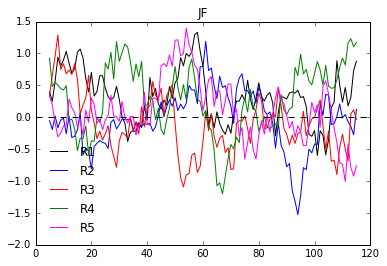

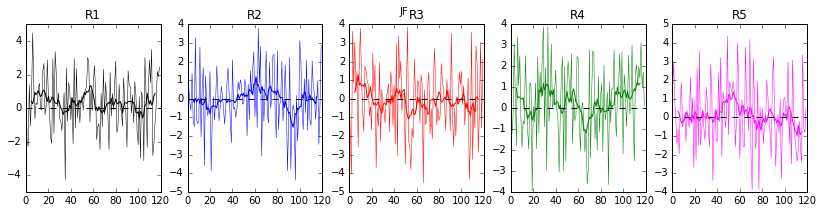

In [122]:
# =============== JF =================


xx=np.arange(0,simfldjfdf.shape[0]) # numyears
window=10
xxrun = xx[window/2:-window/2+1]

clrs=('k','b','r','g','magenta')
lgstr = simfldjfdf.keys()


plt.figure()
for ii in range(0,simfldjfdf.shape[1]):
    
    #plt.plot(xx,simflddf.values[:,ii],color=clrs[ii])
    plt.plot(xxrun, runmean(simfldjfdf.values[:,ii], window=window),color=clrs[ii])

plt.axhline(y=0,linestyle='--',color='k')
plt.legend(lgstr,frameon=False,loc='best')
plt.title(sea3)

fig,axs = plt.subplots(1,5,figsize=(14,3))
for ii in range(0,simfldjfdf.shape[1]):
    ax=axs[ii]
    ax.plot(xx,simfldjfdf.values[:,ii],color=clrs[ii],linewidth=.5)
    ax.plot(xxrun, runmean(simfldjfdf.values[:,ii], window=window),color=clrs[ii])

    ax.set_title(simfldjfdf.keys()[ii])
    ax.axhline(y=0,linestyle='--',color='k')
fig.suptitle(sea3)

In [53]:

# cherry pick R3 for JF cold periods

r3jf=simfldjfdf['R3']
# get r2 ctl and pert separately
r3jfctl = pd.DataFrame(lmd.loaddata((simfield1,),('R3',),ncfields=(simncfield1,), 
                                     timefreq=sea3, region=region,filetype='ctl'))*simconv1
r3jfpt = pd.DataFrame(lmd.loaddata((simfield1,),('R3',),ncfields=(simncfield1,), 
                                     timefreq=sea3, region=region,filetype='pert'))*simconv1


@@ probably should invert the order such that it is field, season, sim?
JF
st ST
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (120, 64, 128)
@@ probably should invert the order such that it is field, season, sim?
JF
st ST
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (120, 64, 128)


In [55]:

styear = 50; enyear=100
tstat,pval = cutl.ttest_ind(r3jfctl[styear:enyear],r3jfpt[styear:enyear])

print '50 - 100 years of R3'
print 'diff ' + str(r3jf[styear:enyear].mean())
print 'tstat,pval ' + str(tstat),str(pval)

print '\ncompare to full time period'

tstat,pval = cutl.ttest_ind(r3jfctl,r3jfpt)
print 'diff ' + str(r3jf.mean())
print 'tstat,pval ' + str(tstat),str(pval)

50 - 100 years of R3
diff -0.401744267515
tstat,pval [ 1.24082717] [ 0.21763182]

compare to full time period
diff -0.102793023094
tstat,pval [ 0.48323234] [ 0.62937502]
